In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2019) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


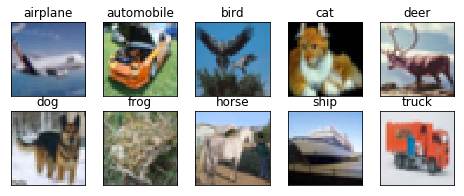

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Data Preprocessing and Preparation

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
import keras
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### Building Model


In [0]:
# Define the model

def model_builder():

  model = Sequential()
  model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(64, 3, 3,border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Convolution2D(32, 1, 1))

  model.add(Convolution2D(64, 3, 3,border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(128, 3, 3,border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))

  model.add(Convolution2D(32, 1, 1))

  model.add(Convolution2D(128, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Convolution2D(256, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Convolution2D(10, 1, 1))
  model.add(AveragePooling2D(pool_size = (4,4)))
  model.add(Flatten())


  model.add(Activation('softmax'))
  
  return model

### Learning rate finder

In [0]:
from keras.callbacks import Callback
import os
import keras.backend as K

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

### Compiling model using 'adam' for finding best learning rate

In [11]:
model = model_builder()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

W0720 04:19:49.429390 139731571160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """
W0720 04:19:49.469177 139731571160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 04:19:49.476720 139731571160960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 04:19:49.522129 139731571160960 deprecation_wrapper.py:119] From /usr/local/lib/pytho

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Adding cutouts

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0,
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))

In [14]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(x_train.shape[0]/64))

model.fit_generator(datagen.flow(x_train, y_train, batch_size = 128),
                                 samples_per_epoch = x_train.shape[0], nb_epoch = 2, 
                                 callbacks=[lr_finder],verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., verbose=1, steps_per_epoch=390, epochs=2)`
  """
W0720 04:19:53.330427 139731571160960 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions

Epoch 1/2
390/390 [==============================] - 31s 80ms/step - loss: 1.9203 - acc: 0.3203
Epoch 2/2
226/390 [================>.............] - ETA: 11s - loss: 2.8688 - acc: 0.3888

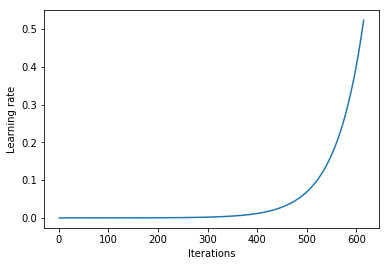

In [15]:
lr_finder.plot_lr()

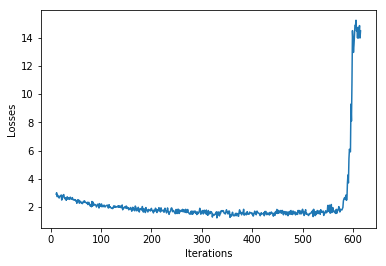

In [16]:
lr_finder.plot_loss()

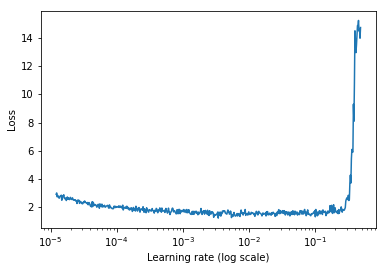

In [17]:
lr_finder.plot()

In [18]:
lr_finder.lrs[:10]

[1.0178238759586835e-05,
 1.0359654424715577e-05,
 1.0544303620156533e-05,
 1.0732243979952901e-05,
 1.092353416540991e-05,
 1.1118233883404617e-05,
 1.1316403905022053e-05,
 1.1518106084523528e-05,
 1.1723403378653033e-05,
 1.1932359866287755e-05]

In [19]:
lr_finder.losses[:10]

[3.0414562,
 2.806971,
 3.0915105,
 2.9613473,
 2.8012955,
 2.8267732,
 3.087771,
 2.9166336,
 2.9510586,
 2.873728]

In [20]:
best_loss = lr_finder.best_loss
print(best_loss)

1.5438867002594319


In [21]:
min(lr_finder.losses)

1.2223884

In [22]:
lr_finder.losses.index(min(lr_finder.losses))

329

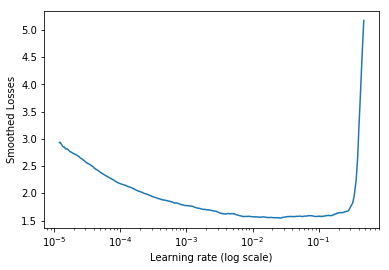

In [23]:
lr_finder.plot_smoothed_loss()

### Best Learning Rate:

As seen from the above graph, the best learning rate is 0.01

In [0]:
new_lr = 0.01

### Compilng and training the model with SGD with New Learning rate 

In [25]:
from keras.callbacks import ReduceLROnPlateau
from keras import optimizers

lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.001, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)

model = model_builder()

sgd = optimizers.SGD(lr=new_lr, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)


datagen = ImageDataGenerator(zoom_range=0.0, 
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))

history = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), callbacks=[lr_reducer],verbose=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API


Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999776482582e-06.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-09.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 5e-10.


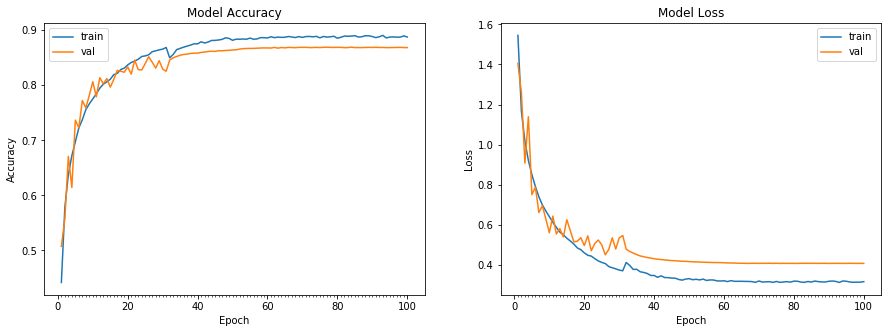

In [26]:
plot_model_history(history)

In [27]:
print("MAX VALIDATION ACCURACY : ",round(max(model.history.history['val_acc']),3))

MAX VALIDATION ACCURACY :  0.869


In [0]:
model.save('model_11.h5')

### Predicting and plotting 25 miss-classified images using Gradcam

In [29]:
predicted = model.predict(test_features)
predicted_classes = np.argmax(predicted,axis=1)
predicted_classes

array([3, 8, 8, ..., 5, 1, 7])

In [30]:
true_classes = np.argmax(test_labels,axis=1)
true_classes

array([3, 8, 8, ..., 5, 1, 7])

In [0]:
count=0
image_index=list()
for i in range(len(true_classes)):
  if predicted_classes[i] != true_classes[i]:
    image_index.append(i)
    count+=1

In [0]:
labels = {0:'airplane', 
          1:'automobile',
          2:'bird',
          3:'cat',
          4:'deer',
          5:'dog',
          6:'frog',
          7:'horse',
          8:'ship',
          9:'truck'}

In [33]:
### For unwanted warnings:


from absl import logging
logging._warn_preinit_stderr = 0
logging.warning('Worrying Stuff')


import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

W0720 05:01:32.053129 139731571160960 <ipython-input-33-695f37074b11>:5] Worrying Stuff


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
__________

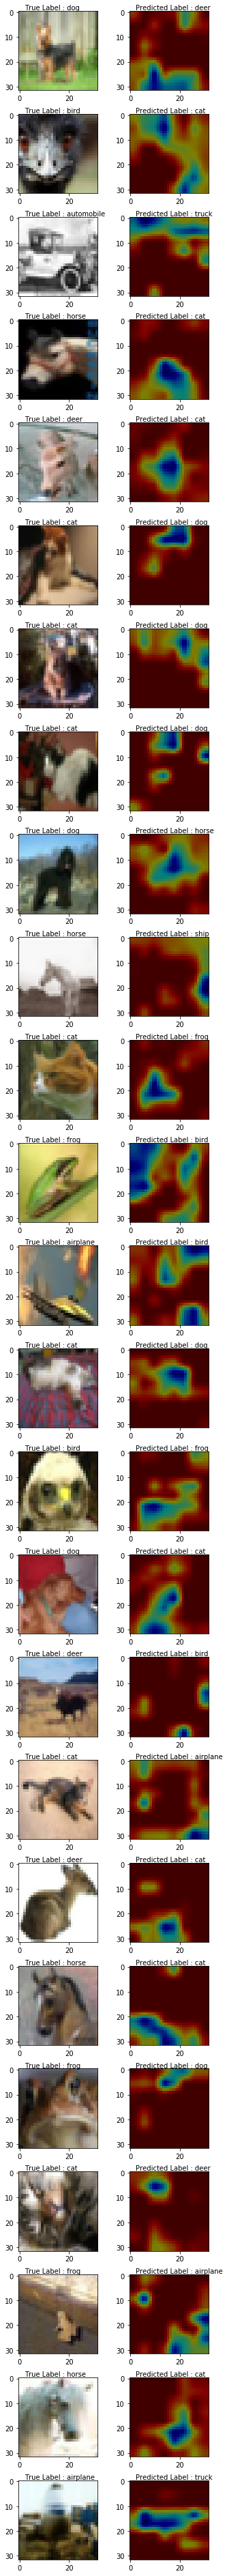

In [35]:
n_row = 25
n_col = 2
k=0
import cv2

from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import backend as K
plt.figure(figsize=(5,40))

for i in range(25):
  true_label = true_classes[image_index[i]]
  predicted_label = predicted_classes[image_index[i]]
  testimage1 = x_test[image_index[i]]
  testimage1 = cv2.resize(testimage1, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(testimage1)
  x = np.expand_dims(x, axis=0)
#   x = preprocess_input(x)
  
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
#   print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_17")
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
#   print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
#   print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis = -1)
#   print(conv_layer_output_value.shape)
#   print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  try:
    heatmap /= np.max(heatmap)
  except:
    print('Can not divided by NaN')
  heatmap = cv2.resize(heatmap, (testimage1.shape[1], testimage1.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  superimposed_img = cv2.addWeighted(testimage1, 0.5, heatmap, 0.5,0,dtype=cv2.CV_32F)
#   print('True Label : ',labels[true_label])
#   print('Predicted Label : ',labels[predicted_label])
  plt.subplot(n_row,n_col,k+1)
  plt.imshow(testimage1)
  plt.text(x=2,y=-1,s='True Label : '+str(labels[true_label]))
  k=k+1
  plt.subplot(n_row,n_col,k+1)
  plt.imshow(superimposed_img.astype(np.uint8))
  plt.text(x=2,y=-1,s='Predicted Label : '+str(labels[predicted_label]))
  k = k+1
  print()
  
plt.subplots_adjust(left  = 0.125,right = 0.9 ,bottom = 0.1 ,top = 1.4  ,wspace = 0.4,hspace = 0.2 )
plt.show()